## Purpose
This notebook is designed to post-process the binary segmentation masks created through manual annotation. Because when drawing the masks by hand, brushes will often cause unwanted artifacts such as:
- Sparkles (Salt Noise): Tiny stray pixels outside the main annotated area.
- Pits (Pepper Noise): Small uncolored gaps or holes inside the intended mask.
- Jagged Boundaries: The "staircase" effect caused by pixel-level brush movements.

This notebook clean up these artifacts to ensure the ground truth data is clean and smoothed before being fed into the model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

**IMPORTANT:** Replace the placeholders below with your own file paths.

In [ ]:
# --- 1. Define File Paths ---
# Ensure the input mask is a binary image (0/255)
INPUT_FOLDER = '/content/drive/MyDrive/FYP/Datasets/Test/selected/groundtruth'
OUTPUT_FOLDER = '/content/drive/MyDrive/FYP/Datasets/Test/selected/groundtruth-cleaned'
FILENAME = 'wound059.jpg'

INPUT_PATH = os.path.join(INPUT_FOLDER, FILENAME)
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, FILENAME)

# Ensure the output directory exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print(f"Loading mask from: {INPUT_PATH}")

Loading mask from: /content/drive/MyDrive/FYP/Datasets/Test/selected_prioritized/groundtruth/wound059.jpg


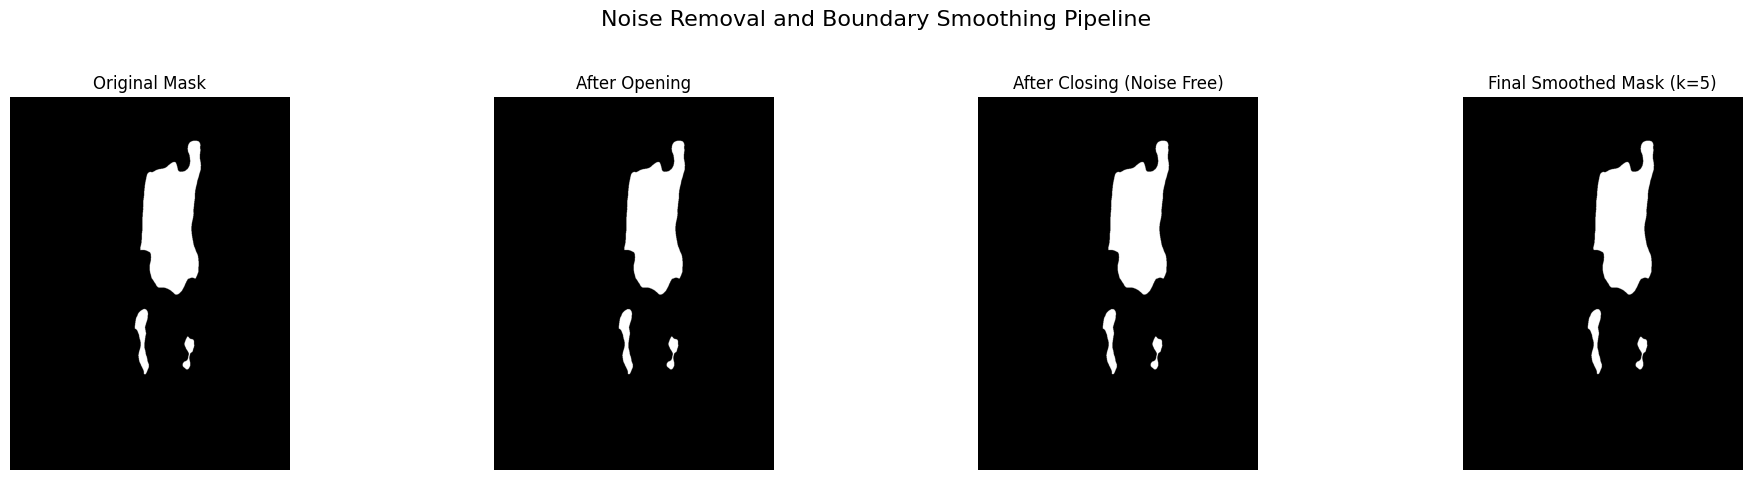


Successfully saved cleaned mask to: /content/drive/MyDrive/FYP/Datasets/Test/selected_prioritized/groundtruth-cleaned/wound059.jpg


In [ ]:
# Load the mask in grayscale (0 is black, 255 is white)
# cv2.IMREAD_GRAYSCALE ensures it is treated as a single channel image
try:
    mask_original = cv2.imread(INPUT_PATH, cv2.IMREAD_GRAYSCALE)

    if mask_original is None:
        raise FileNotFoundError(f"Error: Could not load image at {INPUT_PATH}")

    # Ensure the mask is treated as a binary image (just in case)
    # Binary images typically have 0 (black/background) and 255 (white/foreground) values.
    ret, mask_binary = cv2.threshold(mask_original, 127, 255, cv2.THRESH_BINARY)

    # --- 2. Perform Morphological Operations ---

    # Define the kernel (structuring element) size.
    # A small kernel (e.g., 3x3 or 5x5) is usually enough to clean brush noise.
    # Increase the kernel size to affect larger noise/gaps, but be careful not to change the true shape.
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # A) Morphological Opening
    # Operation: Erosion followed by Dilation.
    # Effect: Removes small white noise (salt noise) outside the main mask.
    mask_opened = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)

    # B) Morphological Closing (Recommended for final cleanup)
    # Operation: Dilation followed by Erosion.
    # Effect: Fills small black holes/gaps (pepper noise) inside the white mask area.
    mask_cleaned = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, kernel)

    # C) Median Filtering for Boundary Smoothing
    # ksize must be an odd number (e.g., 3 or 5).
    # Use a ksize of 5 for noticeable smoothing.
    median_ksize = 5
    mask_smoothed = cv2.medianBlur(mask_cleaned, median_ksize)

    # --- 3. Save the Final Mask ---

    # Save the final smoothed and cleaned image
    cv2.imwrite(OUTPUT_PATH, mask_smoothed)
    print(f"\nSuccessfully saved cleaned mask to: {OUTPUT_PATH}")

except FileNotFoundError as e:
    print(e)
    print("\nPlease double-check your file paths and ensure the image file exists.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")